In [ ]:
import tensorflow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Model
from keras.preprocessing import image

from tensorflow.keras.regularizers import l2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow


from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.utils import shuffle

In [ ]:
from keras.initializers import glorot_uniform


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """ 
    An identity block.

    Parameters
    ----------
    input_tensor:

    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer seed here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation, when addition
    # is performed on convolutional layers, the element-wise addition is performed
    # on their feature maps, i.e. channel by channel
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """ 
    A block that has a conv layer at shortcut.

    Parameters
    ----------
    input_tensor:
    
    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.
        
    strides : tuple, default (2, 2)
        Strides for the first conv layer in the block.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format,
    # which is the case if we are using the default
    # keras' backend tensorflow
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer set here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=strides,
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    # we resize the input so its dimension will match the output dimension
    # of the main path
    shortcut = layers.Conv2D(filters3, kernel_size=(1, 1), strides=strides,
                             kernel_initializer=glorot_uniform(seed=0),
                             padding='valid', name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut) 

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
from keras.datasets import cifar10
from keras.utils import np_utils


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')
print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')

170508288/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) train samples
(10000, 32, 32, 3) test samples
(50000, 1) train labels
(10000, 1) test labels


In [ ]:
y_train


array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

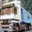

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


In [ ]:
cv2_imshow(x_train[1])
print(x_train[0])

In [ ]:
n_classes = 10
img_rows, img_cols, img_channel = 32, 32, 3

# mnist is grey-scaled image, thus the last dimension, channel size will be 1
X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channel)
X_test  =  x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channel)
input_shape = img_rows, img_cols, img_channel

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train /= 255
X_test /= 255
print('train shape:', X_train.shape)

# one-hot encode the class (target) vectors
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test , n_classes)
print('Y_train shape:', Y_test.shape)

train shape: (50000, 32, 32, 3)
Y_train shape: (10000, 10)


In [ ]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
def ResNet(input_shape, n_classes):
    """
    Definition of ResNet
    
    References
    ----------
    https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
    """
    img_input = layers.Input(shape=input_shape)
    
    bn_axis = 3
    
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # the commented out blocks are what's needed to build out the
    # full ResNet50 (a ResNet with 50 layers), we won't be needing
    # the complexity here
    # x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    img_output = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)
    #img_output = layers.Dense(n_classes, kernel_regularizer=tensorflow.keras.regularizers.l2(0.01),activation
     #        ='softmax' , name = 'fc' + str(n_classes))(x); 
    model = Model(inputs=img_input, outputs=img_output, name='resnet')
    return model


model = ResNet(input_shape, n_classes)
#model.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
history = model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/200
1563/1563 [==============================] - 81s 30ms/step - loss: 1.3761 - accuracy: 0.5093 - val_loss: 1.5169 - val_accuracy: 0.4810
Epoch 2/200
1563/1563 [==============================] - 46s 29ms/step - loss: 0.9676 - accuracy: 0.6585 - val_loss: 1.8940 - val_accuracy: 0.4730
Epoch 3/200
1563/1563 [==============================] - 46s 29ms/step - loss: 0.7935 - accuracy: 0.7232 - val_loss: 1.4431 - val_accuracy: 0.5543
Epoch 4/200
1563/1563 [==============================] - 46s 29ms/step - loss: 0.6714 - accuracy: 0.7665 - val_loss: 1.1067 - val_accuracy: 0.6300
Epoch 5/200
1563/1563 [==============================] - 46s 29ms/step - loss: 0.5793 - accuracy: 0.7976 - val_loss: 0.7931 - val_accuracy: 0.7345
Epoch 6/200
1563/1563 [==============================] - 46s 29ms/step - loss: 0.4909 - accuracy: 0.8288 - val_loss: 1.0225 - val_accuracy: 0.7044
Epoch 7/200
1563/1563 [==============================] - 46s 29ms/step - loss: 0.4163 - accuracy: 0.8549 - val_loss: 0

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Loss = ' + str(loss))
print('Test Accuracy = ' + str(accuracy))

313/313 [==============================] - 3s 11ms/step - loss: 1.7466 - accuracy: 0.7848
Loss = 1.7465912103652954
Test Accuracy = 0.7847999930381775


In [ ]:
#!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-yrb3wqob/cleverhans_ec91e4fa59cb4567b4ba3933364054fa
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-yrb3wqob/cleverhans_ec91e4fa59cb4567b4ba3933364054fa
     |████████████████████████████████| 154 kB 13.1 MB/s 
     |████████████████████████████████| 41 kB 530 kB/s 
  Created wheel for cleverhans: filename=cleverhans-4.0.0-py3-none-any.whl size=92423 sha256=85183486970ceb1c6d49c616e240b40d9fe15363a75b7bee896636b906123588
  Stored in directory: /tmp/pip-ephem-wheel-cache-z5g4d7b1/wheels/60/54/1e/97e3fe32d62bd252c9fbbee44a0545028c6018b81c054af3e4
Successfully built cleverhans


In [ ]:
# Import the attack
from cleverhans.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)
print(logits_model)

In [ ]:
def adv_generate(X_images):
  images = []
  labels = []
  adv_orig_images = []
  adv_orig_labels = []
  epsilon = 0.1

  for item in X_images:
    #cv2_imshow(item)
    adv_orig_images.append(item)
    adv_orig_labels.append(0)

    original_image = tf.convert_to_tensor(item.reshape((1,32,32,3))) 
    adv_img = fast_gradient_method.fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)
    adv_img = np.reshape(adv_img, (1,32,32,3))

    adv_labels = model.predict(adv_img)
    images.append(np.reshape(adv_img, (32,32,3)))
    #print(adv_labels)
    labels.append(np.reshape(adv_labels,(10)))

    adv_orig_images.append(np.reshape(adv_img,(32,32,3)))
    adv_orig_labels.append(1)

  images = np.array(images)
  labels = np.array(labels)
  adv_orig_images = np.array(adv_orig_images)
  adv_orig_labels = np.array(adv_orig_labels)
  labels = labels.reshape(-1, 1) 
  adv_orig_labels = adv_orig_labels.reshape(-1, 1) 
  #adv_orig_images,adv_orig_labels = shuffle( adv_orig_images, adv_orig_labels, random_state=4)
  return images, labels, adv_orig_images, adv_orig_labels
  

  

In [ ]:

x_train_adv, y_train_adv, X_train_adv_orig, Y_train_adv_orig = adv_generate(x_train)


In [ ]:
x_test_adv, y_test_adv, X_test_adv_orig, Y_test_adv_orig = adv_generate(x_test)

In [ ]:
x_test_adv.shape
#X_test_adv_orig.shape

(10000, 32, 32, 3)

In [ ]:

Y_train_adv_orig.shape

(100000,)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pyyaml h5py 

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.6.0


In [ ]:
!mkdir -p saved_model
model.save('/content/gdrive/MyDrive/saved_model/SafetyNet_cifar_99_78') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/saved_model/SafetyNet_cifar_99_78/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')


In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(X_test, Y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(X_test).shape)

313/313 - 3s - loss: 1.7466 - accuracy: 0.7848
Restored model, accuracy: 78.48%
(10000, 10)


In [ ]:
Y_test_adv_orig.shape

(400000, 1)

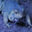

In [ ]:
cv2_imshow(x_test[5])


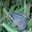

In [ ]:
cv2_imshow(np.reshape(x_test_adv[4], (32,32,3)))

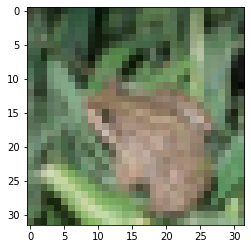

In [ ]:

plt.imshow(np.reshape(x_test_adv[4], (32,32,3)).astype(int))

In [ ]:



Y_train_adv_orig.shape

(14400000, 2)

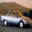

In [ ]:
cv2_imshow(np.reshape(x_train_adv[4], (32,32,3)))

In [ ]:
x_train_adv.shape

(50000, 32, 32, 3)

In [ ]:
Y_train_adv_orig

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
#X_train_adv_orig.shape[0]
X_train_adv_orig.shape[0]

100000

In [ ]:
img_rows, img_cols, img_channel = 32, 32, 3

# mnist is grey-scaled image, thus the last dimension, channel size will be 1
X_train_adv_orig = X_train_adv_orig.reshape(X_train_adv_orig.shape[0], img_rows, img_cols, img_channel)
X_test_adv_orig =  X_test_adv_orig.reshape(X_test_adv_orig.shape[0], img_rows, img_cols, img_channel)
input_shape = img_rows, img_cols, img_channel

X_train_adv_orig = X_train_adv_orig.astype('float32')
X_test_adv_orig  = X_test_adv_orig.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train_adv_orig /= 255
X_test_adv_orig /= 255
print('train shape:', X_train_adv_orig.shape)
# one-hot encode the class (target) vectors
#Y_train_adv_orig = np_utils.to_categorical(Y_train_adv_orig, nb_classes1)
#Y_test_adv_orig = np_utils.to_categorical(Y_train_adv_orig, nb_classes1)
print('Y_train shape:', Y_train_adv_orig.shape)
print(X_test_adv_orig.shape)

train shape: (100000, 32, 32, 3)
Y_train shape: (100000,)
(20000, 32, 32, 3)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])],     remainder='passthrough')
Y_train_adv_orig=np.array(columnTransformer.fit_transform(Y_train_adv_orig),dtype=np.float)
Y_train_adv_orig.shape


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])],     remainder='passthrough')
Y_test_adv_orig=np.array(columnTransformer.fit_transform(Y_test_adv_orig),dtype=np.float)
Y_test_adv_orig.shape


In [ ]:
def ResNet1(input_shape, n_classes):
    """
    Definition of ResNet
    
    References
    ----------
    https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
    """
    img_input1 = layers.Input(shape=input_shape)
    
    bn_axis = 3
    
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input1)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # the commented out blocks are what's needed to build out the
    # full ResNet50 (a ResNet with 50 layers), we won't be needing
    # the complexity here
    # x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    #img_output = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)
    img_output1 = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)
             #='linear' , name = 'fc' + str(n_classes))(x); 
    model1 = Model(inputs=img_input1, outputs=img_output1, name='resnet1')
    return model1

model1 = ResNet1(input_shape, 2)
model1.compile(optimizer = 'adam', loss ='categorical_entropy', metrics = ['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model1.summary()

In [ ]:
Y_train_adv_orig.shape

(14400000, 2)

In [ ]:
len(Y_train_adv_orig)

14400000

In [ ]:
history1 = model1.fit(X_train_adv_orig, Y_train_adv_orig, epochs=200, batch_size=32, validation_data=(X_test_adv_orig, Y_test_adv_orig))

ValueError: ignored

In [ ]:
Y_test_adv_orig

In [ ]:

loss, accuracy = model1.evaluate(X_test_adv_orig, Y_test_adv_orig)
print('Loss = ' + str(loss))
print('Test Accuracy = ' + str(accuracy))